In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

def get_layer_embeddings(model, tokenizer, texts, max_length=512):
    all_layers_embeddings = []
    
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get all hidden states
        hidden_states = outputs.hidden_states
        
        # Convert hidden states to numpy arrays and store
        text_embeddings = [state.squeeze(0).detach().numpy() for state in hidden_states]
        all_layers_embeddings.append(text_embeddings)
    
    return all_layers_embeddings

def calculate_layer_statistics(embeddings, num_layers):
    avg_cosine_sims = []
    intra_sent_sims = []
    
    # Skip the first layer (embedding layer) and process each subsequent layer
    for layer_idx in range(1, num_layers + 1):
        # Get embeddings for this layer across all sentences
        layer_embeddings = [sent_embed[layer_idx] for sent_embed in embeddings]
        
        # Calculate average cosine similarity between random token pairs
        cosine_sims = []
        for emb in layer_embeddings:
            if len(emb) >= 2:  # Ensure we have at least 2 tokens
                idx1, idx2 = np.random.choice(len(emb), 2, replace=False)
                sim = cosine_similarity(emb[idx1:idx1+1], emb[idx2:idx2+1])[0][0]
                cosine_sims.append(sim)
        
        avg_cosine_sims.append(np.mean(cosine_sims))
        
        # Calculate intra-sentence similarity
        intra_sims = []
        for emb in layer_embeddings:
            sim_matrix = cosine_similarity(emb)
            # Exclude self-similarity from diagonal
            mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
            intra_sims.append(sim_matrix[mask].mean())
        
        intra_sent_sims.append(np.mean(intra_sims))
    
    return avg_cosine_sims, intra_sent_sims

def plot_layer_statistics(bert_stats, gpt2_stats, title, ylabel):
    layers = list(range(1, len(bert_stats) + 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(layers, bert_stats, 'bo-', label='BERT', linewidth=2, markersize=8)
    plt.plot(layers, gpt2_stats, 'ro-', label='GPT-2', linewidth=2, markersize=8)
    
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [3]:

# Załadowanie danych
dataset = load_dataset("clarin-knext/wsd_polish_datasets", split="train", trust_remote_code=True)
sample_texts = dataset["text"][:50]  # Zmniejszamy próbkę dla szybszości


In [4]:

# Załadowanie modeli
bert_model_name = "bert-base-multilingual-cased"  # Zmiana na model wielojęzyczny
gpt2_model_name = "flax-community/papuGaPT2"  # Polski model GPT-2


In [5]:

bert_model = AutoModel.from_pretrained(bert_model_name, output_hidden_states=True)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

gpt2_model = AutoModel.from_pretrained(gpt2_model_name, output_hidden_states=True)
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token


In [6]:

# Uzyskanie embeddingów
bert_embeddings = get_layer_embeddings(bert_model, bert_tokenizer, sample_texts)
gpt2_embeddings = get_layer_embeddings(gpt2_model, gpt2_tokenizer, sample_texts)


In [7]:

# Obliczenie statystyk dla warstw
bert_cosine_sims, bert_intra_sims = calculate_layer_statistics(bert_embeddings, 12)
gpt2_cosine_sims, gpt2_intra_sims = calculate_layer_statistics(gpt2_embeddings, 12)


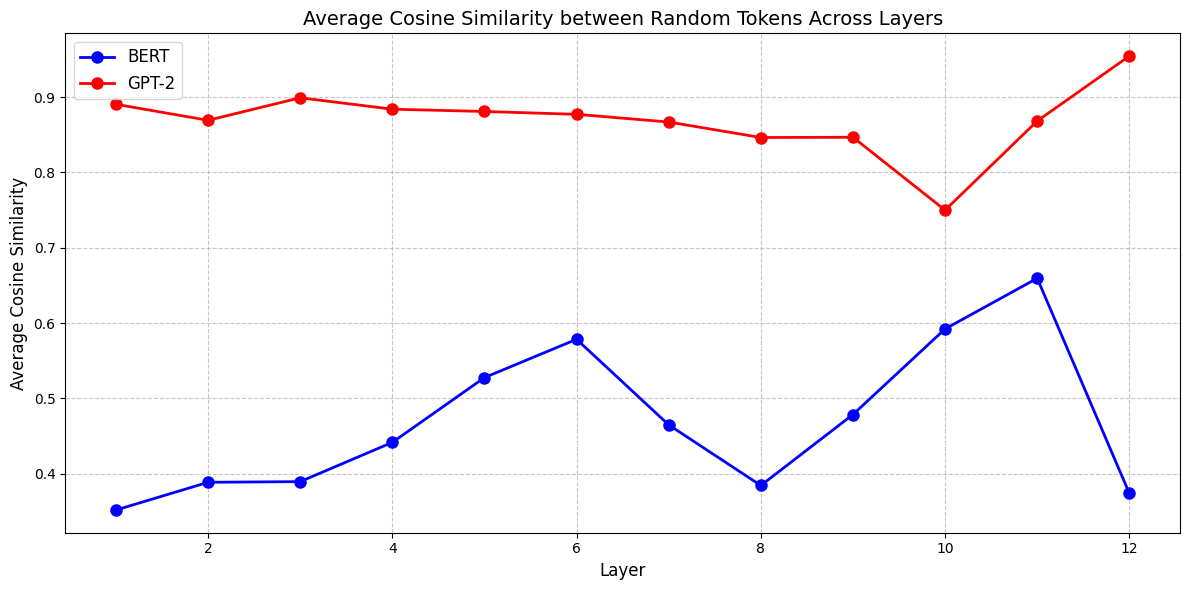

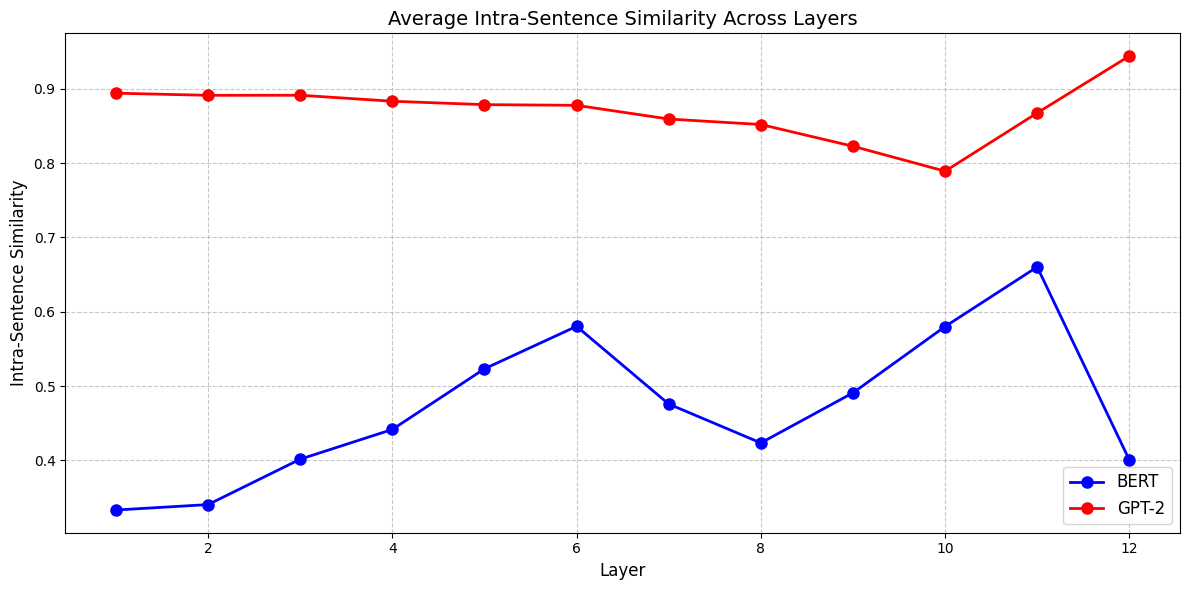

In [8]:

# Generowanie wykresów
plot_layer_statistics(
    bert_cosine_sims, 
    gpt2_cosine_sims,
    "Average Cosine Similarity between Random Tokens Across Layers",
    "Average Cosine Similarity"
)

plot_layer_statistics(
    bert_intra_sims,
    gpt2_intra_sims,
    "Average Intra-Sentence Similarity Across Layers",
    "Intra-Sentence Similarity"
)